# Preparation of Notebook and Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install transformers
!pip install tweet-preprocessor
import transformers
from transformers import *
from transformers import BertForSequenceClassification, AdamW, BertConfig

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
import preprocessor as p
import pandas as pd
import numpy as np
import pandas as pd
import time
import datetime
import random
import io

%matplotlib inline  
print('Transformers version: ', transformers.__version__)
print('Tensorflow version: ', tf.__version__)

     |████████████████████████████████| 501kB 4.7MB/s 
     |████████████████████████████████| 870kB 60.9MB/s 
     |████████████████████████████████| 1.0MB 37.1MB/s 
     |████████████████████████████████| 3.7MB 57.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=21b6a47ad3544d91869eb42be67869de2ce8bd33bdd192efa7cf8bd4e60ba1ab
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=d40ad46b71ca1afeb00d4cc01e09149b656a0f27ed224c6f6a71ee30145d5133
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


Transformers version:  2.5.1
Tensorflow version:  1.15.0


Using TensorFlow backend.


In [0]:
# If there's a GPU available...
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Importing Dataset

In [0]:
#importing all datasets
sandy_df = pd.read_csv('./drive/My Drive/GA/capstone/data/2012_Sandy_Hurricane-ontopic_offtopic.csv')
alberta_df = pd.read_csv('./drive/My Drive/GA/capstone/data/2013_Alberta_Floods-ontopic_offtopic.csv')
boston_df = pd.read_csv('./drive/My Drive/GA/capstone/data/2013_Boston_Bombings-ontopic_offtopic.csv')
oklahoma_df = pd.read_csv('./drive/My Drive/GA/capstone/data/2013_Oklahoma_Tornado-ontopic_offtopic.csv')
queensland_df = pd.read_csv('./drive/My Drive/GA/capstone/data/2013_Queensland_Floods-ontopic_offtopic.csv')
west_texas_df = pd.read_csv('./drive/My Drive/GA/capstone/data/2013_West_Texas_Explosion-ontopic_offtopic.csv')
super_df = pd.concat([sandy_df,alberta_df,boston_df,oklahoma_df,queensland_df,west_texas_df])
super_df.shape

(60082, 3)

# Data Cleaning

In [0]:
import regex as re
def tidy_up(dataframe): #renaming columns to remove the 'space' and to change the label to binary.
  dataframe.rename(columns={" tweet":"tweet"," label":"label"},inplace=True)
  dataframe.label = dataframe.label.map({'off-topic':0,'on-topic':1})
  dataframe.drop(columns=['tweet id'],inplace=True)
  dataframe.drop_duplicates(subset='tweet',keep='last',inplace=True)
  p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
  dataframe['tweet']=[p.clean(x) for x in dataframe['tweet']]
  dataframe['tweet']=[re.sub(r'(&amp;)|(&lt;)|(b&gt;)|([!?.]*[!?.])',"",x) for x in dataframe['tweet']]

In [0]:
tidy_up(super_df)
super_df['bert_predict'] = 0
super_df.sample(5)

,tweet,label,bert_predict
9266,: The #Siksika First Nation near Calgary has a...,1,0
3453,will never notice me and it kills me,0,0
9833,#yycflood This page is for anyone in Calgary s...,1,0
4993,excuse me You're the one who showed them your ...,0,0
3153,Having the option to sleep all day is amazing,0,0


In [0]:
super_df.label.value_counts()

1    27879
0    27498
Name: label, dtype: int64

# Loading fine-tuned model

In [0]:
output_dir = './drive/My Drive/GA/capstone/BERT with cleaned tweets' #loading cleaned tweets BERT

model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Prediction

In [0]:
super_df['bert_predict_clean'] = 0

# Create sentence and label lists
tweets = super_df.tweet.values
labels = super_df.bert_predict_clean.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for tweet in tweets:
    encoded_tweet = tokenizer.encode( tweet, add_special_tokens = True )
    input_ids.append(encoded_tweet)

# Pad our input tokens
MAX_LEN = max([len(i) for i in input_ids])
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Predictions

print('Predicting labels for {:,} tweets...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_clean , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_clean.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 55,377 tweets...
    DONE.


In [0]:
clean_flat_prediction = [item for sublist in predictions_clean for item in sublist]
clean_flat_predictions = np.argmax(clean_flat_prediction, axis=1).flatten()
super_df['bert_predict_clean'] = clean_flat_predictions

In [0]:
tn, fp, fn, tp = confusion_matrix(super_df['label'], super_df['bert_predict_clean']).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy: {round(accuracy_clean,4)}')

misclass_clean = (fp + fn) / (tp + tn + fp + fn)
print(f'Misclassification Rate: {round(misclass_clean,4)}')

spec_clean = tn / (tn + fp) #how many of the 'spam' was correctly classified
print(f'Specificity: {round(spec_clean,4)}')

sens_clean = tp / (tp + fn) #how many of the disasters was correctly identified
print(f'Sensitivity: {round(sens_clean,4)}')

True Negatives: 25785
False Positives: 1713
False Negatives: 6346
True Positives: 21533
Accuracy: 0.8545
Misclassification Rate: 0.1455
Specificity: 0.9377
Sensitivity: 0.7724


In [0]:
pd.set_option('display.max_colwidth', -1)
super_df.loc[super_df['bert_predict']!=super_df['label']]['tweet'].sample().to_string()

"7047    Hurricane sandy is on it's way"

In [0]:
super_df.to_csv('./drive/My Drive/GA/capstone/super_df.csv')

In [0]:
super_df.head(2)

,tweet,label,bert_predict,bert_predict_clean
0,I've got enough candles to supply a Mexican family,0,0,0
1,Sandy be soooo mad that she be shattering our doors and shiet #HurricaneSandy,1,0,0


BERT struggled when the texts are not referring directly to the disaster that is occuring. It also seems to miss the tweets with a more positive sentiment in the message.

BERT is able to identify some of the mislabelled tweets correctly as disaster related. It seems to be able to pick up tweets describing adverse weather and may classify them as disaster-related.

# Visualisations

Visualisation of predictions

In [0]:
def tweet_length_graph(df,col,label,color,kde):
    tweet_length = []
    for x in df[col]:
        tweet_length.append(len(x.split()))
    sns.distplot(tweet_length,kde=kde,bins=np.arange(min(tweet_length), max(tweet_length) + 1),label=label,color=color)
    plt.title('Words in Tweets')
    plt.ylabel('Frequency')
    plt.xlabel('Tweet Length')
    

(1713, 4)
(6346, 4)


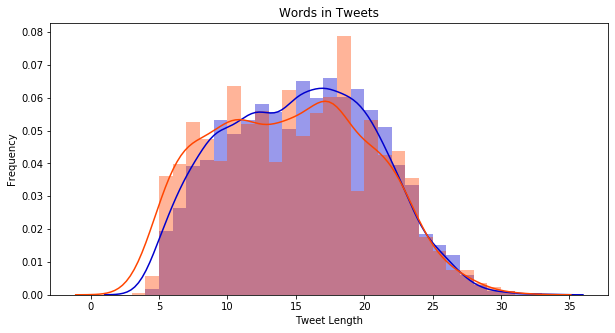

In [0]:
bert_yes = super_df.loc[(super_df['bert_predict_clean']==1) & (super_df['label']==0)]
bert_no = super_df.loc[(super_df['bert_predict_clean']==0) & (super_df['label']==1)]
print(bert_yes.shape)
print(bert_no.shape)
plt.figure(figsize=(10,5))
tweet_length_graph(bert_no,'tweet','ACTUAL','mediumblue',True)
tweet_length_graph(bert_yes,'tweet','BERT','orangered',True)


In [0]:
super_df.loc[super_df['bert_predict_clean']!=super_df['label']][['tweet','label','bert_predict_clean']].sample(10)

,tweet,label,bert_predict_clean
9026,Scratch that Two buses now #abflood,1,0
6539,": Everyone send well wishes to keep her mind away from the things happening in her home town, Oklahoma Stay…",1,0
9421,: This mothafucka just tweeted On my way back MDDa Fuck BACK Nigga we bout to have a hurricaneyou better,1,0
9168,Tornado Alley To Spark Up After Mid-May —,0,1
6086,": Patriots owner Robert Kraft will match donations, up to $100,000, made to this website for Boston Marathon relief htt",1,0
2612,So a big storm is about to smack Brisbane Fak u gooby Had enough last weekend,0,1
2829,We live right by there Want to help Pls tweet if u find info on how to help,1,0
773,Lost power when I was about to taste my first bite out of my sandwich Lmao thank God it's back,1,0
5150,: Here's a view of the sea of volunteers at McMahon So proud of my city #yycflood #yychelps,1,0
6522,“: what if gangnam style was really a giant raindance and we brought this hurricane on ourselves”,1,0
